# Processing `tub-north` simulations

This notebook contains routines to process and reduce data for the `tub-north` simulations. 

For analysis and plots showing this data, see `RuntimeAnalysis.ipynb`.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.18:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
client = Client('tcp://10.0.64.18:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.18:8786 Dashboard: http://10.0.64.18:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [3]:
db='/home/157/amh157/tub-north/tub-north.db'
exptdict = OrderedDict([
    ('tx01-fc00',   {'expt':'tub-north-tx01-fc00','start_time':'1100-01-01'}),
    ('tx01-fc005',   {'expt':'tub-north-tx01-fc005','start_time':'1100-01-01'}),
    ('tx01-fc01',   {'expt':'tub-north-tx01-fc01','start_time':'1100-01-01'}),
    ('tx01-fc03',   {'expt':'tub-north-tx01-fc03','start_time':'1100-01-01'}),
    ('tx00-fc02',   {'expt':'tub-north-tx00-fc02','start_time':'1100-01-01'}),
    ('tx00-fc02-pert',   {'expt':'tub-north-tx00-fc02-pert','start_time':'1100-01-01'}),
    ('tx005-fc02',   {'expt':'tub-north-tx005-fc02','start_time':'1100-01-01'}),
    ('tx01-fc02',   {'expt':'tub-north-tx01-fc02','start_time':'1100-01-01'}),
    ('tx02-fc02',   {'expt':'tub-north-tx02-fc02','start_time':'1100-01-01'}),
    ('GM',   {'expt':'tub-north-GM','start_time':'1100-01-01'})
])
processed = '/g/data/v45/amh157/tub-north-processed/'

## Database
Update the database here.

In [4]:
session = cc.database.create_session(db)

In [6]:
cc.database.build_index(glob.glob('/g/data/v45/amh157/mom6/archive/*'),session,update=True)

Indexing experiment: tub-north-tx01-fc03


0it [00:00, ?it/s]


Indexing experiment: tub-north-tx01-fc02


0it [00:00, ?it/s]
0it [00:00, ?it/s]


Indexing experiment: tide_test_v3
Indexing experiment: tub-north-tx00-fc02


0it [00:00, ?it/s]


Indexing experiment: tub-north-tx02-fc02


0it [00:00, ?it/s]


Indexing experiment: tub-north-tx01-fc005


0it [00:00, ?it/s]


Indexing experiment: tub-north-GM


0it [00:00, ?it/s]


Indexing experiment: tub-north-tx00-fc05


0it [00:00, ?it/s]


Indexing experiment: tub-north-tx01-fc00


0it [00:00, ?it/s]
0it [00:00, ?it/s]


Indexing experiment: tide_test_v2
Indexing experiment: tub-north-ref


0it [00:00, ?it/s]


Indexing experiment: tub-north-tx01-fc01


0it [00:00, ?it/s]
0it [00:00, ?it/s]


Indexing experiment: tide_test
Indexing experiment: tub-north-tx00-fc02-pert


0it [00:00, ?it/s]


Indexing experiment: tub-north-tx005-fc02


0it [00:00, ?it/s]


0

## Experiments and Start Time
We have 3 experiments so far. Starting diagnostics from year `start_time`.

In [7]:
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, 'taux', session).Time
    start_year = cftime.date2num(darray[0],units='days since 0001-01-01',calendar='julian')/365
    end_year = cftime.date2num(darray[-1],units='days since 0001-01-01',calendar='julian')/365
    print(expt,': - Goes from year ',start_year.round(),' to year ', end_year.round())
    print('          - start_time = ',start_time)
    print('  ')

tub-north-tx01-fc00 : - Goes from year  1006.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx01-fc005 : - Goes from year  1006.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx01-fc01 : - Goes from year  1006.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx01-fc03 : - Goes from year  1006.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx00-fc02 : - Goes from year  0.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx00-fc02-pert : - Goes from year  1006.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx005-fc02 : - Goes from year  1006.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx01-fc02 : - Goes from year  110.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-tx02-fc02 : - Goes from year  1006.0  to year  1206.0
          - start_time =  1100-01-01
  
tub-north-GM : - Goes from year  1006.0  to year  1206.0
    

## Spinup Diagnostics
The aim for these runs is to get heat and age stable, and then to branch off perturbations.

Text(0.5,0,'Time (years)')

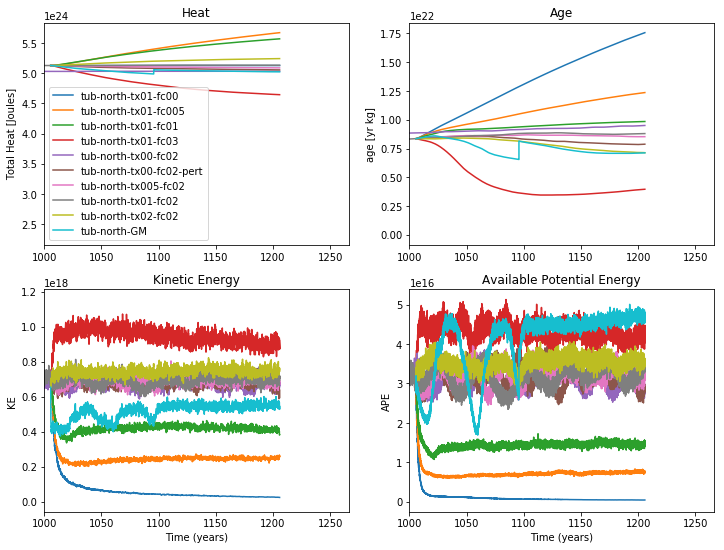

In [8]:
## Spinups
fig, ax = plt.subplots(2,2,figsize=(12,9))

for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).Heat
    darray.coords['Time'] = darray.coords['Time']/365
    darray.plot(ax=ax[0,0], label=expt)

    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).age
    darray.coords['Time'] = darray.coords['Time']/365
    darray.plot(ax=ax[0,1],label=expt)
    
    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).KE
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sum('Layer').plot(ax=ax[1,0],label=expt)
    
    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).APE
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sum('Interface').plot(ax=ax[1,1], label=expt)
    
ax[0,0].set_title('Heat')
ax[0,0].legend()
ax[0,0].set_xlabel('')
ax[0,0].set_xlim(xmin=1000)
ax[1,0].set_xlim(xmin=1000)
ax[0,1].set_xlim(xmin=1000)
ax[1,1].set_xlim(xmin=1000)

ax[0,1].set_title('Age')
ax[0,1].set_xlabel('')
ax[1,0].set_title('Kinetic Energy')
ax[1,0].set_xlabel('Time (years)')
ax[1,1].set_title('Available Potential Energy')
ax[1,1].set_xlabel('Time (years)')

## Mixed Layer Depth

In [10]:
variable = 'mlotst'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session, start_time=start_time )
    MLD = darray.mean('Time')
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc01/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02-pert/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx005-fc02/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx02-fc02/mlotst_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-GM/mlotst_averaged.nc


In [17]:
# Timeseries of mean MLD north of 55N
variable = 'mlotst'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = cc.querying.getvar(expt, variable, session, start_time='1000-01-01')
    MLD = darray.resample(Time='A').mean('Time').mean('xh').sel(yh=slice(55,None)).mean('yh')
    FileName = processed+expt+'/'+variable+'_timeseries.nc'
    MLD.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc01/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02-pert/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx005-fc02/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx02-fc02/mlotst_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-GM/mlotst_timeseries.nc


## Heat Flux


In [12]:
variable = 'heat_added'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session, start_time=start_time)
    HF = darray.mean('Time')
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    HF.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc01/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02-pert/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx005-fc02/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx02-fc02/heat_added_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-GM/heat_added_averaged.nc


In [5]:
variable = 'heat_added'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = cc.querying.getvar(expt, variable, session, start_time='1000-01-01')
    HFn = darray.resample(Time='A').mean('Time').mean('xh').sel(yh=slice(50,None)).mean('yh')
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn.to_netcdf(FileName)
    print('Done'+FileName)
    HFs = darray.resample(Time='A').mean('Time').mean('xh').sel(yh=slice(10,30)).mean('yh')
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFs.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx005-fc02/heat_added_north_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx005-fc02/heat_added_south_timeseries.nc


## SSH

In [14]:
variable = 'SSH'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session,start_time=start_time)
    SSH = darray.mean('Time')
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSH.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc01/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02-pert/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx005-fc02/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx02-fc02/SSH_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-GM/SSH_averaged.nc


In [19]:
variable = 'SSH'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = cc.querying.getvar(expt, variable, session, start_time='1000-01-01')
    SSHmin = darray.resample(Time='A').mean('Time').mean('xh').sel(yh=slice(50,None)).mean('yh')
    FileName = processed+expt+'/'+variable+'_min_timeseries.nc'
    SSHmin.to_netcdf(FileName)
    print('Done'+FileName)
    SSHmax = darray.resample(Time='A').mean('Time').mean('xh').sel(yh=slice(10,30)).mean('yh')
    FileName = processed+expt+'/'+variable+'_max_timeseries.nc'
    SSHmax.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/SSH_min_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/SSH_max_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/SSH_min_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/SSH_max_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc01/SSH_min_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc01/SSH_max_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/SSH_min_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/SSH_max_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02/SSH_min_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02/SSH_max_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02-pert/SSH_min_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-

## Upper ocean streamfunction

In [8]:
variable = 'vh_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session, start_time=start_time)/1e6
    psi = darray.mean('Time').sel(rho_l=slice(None,1034)).sum('rho_l').cumsum('xh')
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/vh_rho_upper_averaged.nc


In [5]:
tmpkeys = ['tx01-fc005']
variable = 'vh_rho'
for ekey in tmpkeys: #exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = cc.querying.getvar(expt, variable, session, start_time='1000-01-01')/1e6
    psi = darray.resample(Time='A').mean('Time').sel(rho_l=slice(None,1034)).sum('rho_l').cumsum('xh').sel(xh=10,method='nearest').max(dim='yq')
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/vh_rho_upper_timeseries.nc


## Lower ocean streamfunction

In [13]:
tmpkeys = ['tx01-fc00']
variable = 'vh_rho'
for ekey in tmpkeys: #exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session, start_time=start_time)/1e6
    psi = darray.mean('Time').sel(rho_l=slice(1034,None)).sum('rho_l').cumsum('xh')
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/vh_rho_lower_averaged.nc


In [7]:
tmpkeys = ['tx01-fc005']
variable = 'vh_rho'
for ekey in tmpkeys: #exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = cc.querying.getvar(expt, variable, session, start_time='1000-01-01')/1e6
    psi = darray.resample(Time='A').mean('Time').sel(rho_l=slice(1034,None)).sum('rho_l').cumsum('xh').sel(xh=10,method='nearest').min(dim='yq')
    FileName = processed+expt+'/'+variable+'_lower_timeseries.nc'
    psi.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/vh_rho_lower_timeseries.nc


## Overturning

In [15]:
tmpkeys = ['tx01-fc02']
variable = 'vh_rho'
for ekey in tmpkeys: #exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session, start_time=start_time)/1e6
    psi = darray.mean('Time').sum('xh').cumsum('rho_l')
    FileName = processed+expt+'/'+variable+'_overturning_averaged.nc'
    psi.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/vh_rho_overturning_averaged.nc


In [6]:
#tmpkeys = ['tx01-fc02']
tmpkeys = ['tx01-fc02','tx01-fc005']
variable = 'vh_rho'
for ekey in tmpkeys: #exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = cc.querying.getvar(expt, variable, session, start_time='1000-01-01')/1e6
    psi = darray.resample(Time='A').mean('Time').sel(yq=slice(20,30)).mean('yq').sum('xh').cumsum('rho_l').sel(rho_l=slice(1034,None)).max(dim='rho_l')
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/vh_rho_overturning_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/vh_rho_overturning_timeseries.nc


## Barotropic streamfunction

In [7]:
tmpkeys = ['tx00-fc02-pert','tx01-fc02','tx01-fc005','tx01-fc00']
variable = 'vh_rho'
for ekey in tmpkeys: #exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session, start_time=start_time)/1e6
    psi = darray.mean('Time').sum('rho_l').cumsum('xh')
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02-pert/vh_rho_barotropic_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/vh_rho_barotropic_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/vh_rho_barotropic_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/vh_rho_barotropic_averaged.nc


In [18]:
tmpkeys = ['GM']
variable = 'vh_rho'
for ekey in tmpkeys: #exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = cc.querying.getvar(expt, variable, session, start_time='1000-01-01')/1e6
    psi = darray.resample(Time='A').mean('Time').sum('rho_l').sel(yq=slice(20,50)).cumsum('xh').sel(xh=10,method='nearest')
    psimin = psi.min(dim='yq')
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin.to_netcdf(FileName)
    print('Done'+FileName)
    psimax = psi.max(dim='yq')
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psimax.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-GM/vh_rho_barotropic_min_timeseries.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-GM/vh_rho_barotropic_max_timeseries.nc


## Stratification

In [16]:
#tmpkeys = ['tx01-fc02','tx02-fc02','GM']
variable = 'h_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    darray = cc.querying.getvar(expt, variable, session, start_time=start_time)
    h = darray.mean('Time').sel(rho_l=slice(None,1034)).sum('rho_l')
    FileName = processed+expt+'/'+variable+'_1034_averaged.nc'
    h.to_netcdf(FileName)
    print('Done'+FileName)

Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc00/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc005/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc01/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc03/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx00-fc02-pert/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx005-fc02/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx01-fc02/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-tx02-fc02/h_rho_1034_averaged.nc
Done/g/data/v45/amh157/tub-north-processed/tub-north-GM/h_rho_1034_averaged.nc
